# PK/PD AL Blood Volume and Hill Equation analyses
# Date: 07/31/2025

## 1. Studying how exponential blood volume affects the ER curve
<br>

In [2]:
import subprocess
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

### a. Default PD model
#### ```patient_blood_volume = weight * 70 * 1000```

#### Instantaeneous hourly killing rate ```a```

$$
(\frac{-1}{24}) \times ln({1.0} - \frac{P_{max}\times{concentration}^n}{{concentration}^n + EC_{50}^n})
$$

#### Killing fraction:
$$
\frac{P_{max}\times concentration^n}{concentration^n + EC_{50}^n}
$$

#### Hourly killing rate:
$$
(\frac{-1}{24}) \times ln({1.0} - killing fraction)
$$

#### Net hourly growth rate:

$g = 0.048$

$ net\,hourly\,growth\,rate = g - \,hourly \,killing \,rate$

#### Calculating BV using the Lemmens-Bernstein-Brodsky Equation

$$
BV = \frac{70}{\sqrt{\frac{BMI}{22}}}
$$

#### Calculating concentration by adding an exponent to patient blood volume

$$
concentration~= \frac{dose}{({weight~\times~\frac{70}{\sqrt\frac{18.5}{22}}})^x}
$$

In [4]:
def generate_recommended_dosing_schedule(weight):
    if weight < 15.0:
        num_tablets_per_dose = 0.50
    elif weight < 25.0:
        num_tablets_per_dose = 1.0
    elif weight < 35.0:
        num_tablets_per_dose = 1.50
    else:
        num_tablets_per_dose = 2.0
    total_mg_dose_per_occassion = num_tablets_per_dose * 40.0;
    return total_mg_dose_per_occassion

In [5]:
def sigmoid_function(concentration, pmax, ec50, n):
    return (pmax * (concentration ** n)) / ((concentration ** n) + (ec50 ** n))

## x = 0.5

In [48]:
# Generating total dose for each weight over 3 days with twice daily dosing
weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
# for i in range(len(weight_values)):
#     print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

for i in range(len(weight_values)):
    total_blood_volume = weight_values[i] * (((70 / np.sqrt(24.9 / 22)))**0.5) 
    lower_limit_concentration.append(lower_limit_mg[i] / total_blood_volume)
    upper_limit_concentration.append(upper_limit_mg[i] / total_blood_volume)

artemether_concentrations_mg_ml_final = []
for i in range(len(weight_values)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 10
ec50_concentrations_ng = [ec50_dose_ng for weight in weight_values] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for weight in weight_values]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

EC50 Concentrations (ng/mL): [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
EC50 Concentrations (mg/mL): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [49]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 5 kg is: 0.0 ng/mL to 2958737.1738622203 ng/mL
Total Concentration range for weight 10 kg is: 0.0 ng/mL to 1479368.5869311101 ng/mL
Total Concentration range for weight 15 kg is: 0.0 ng/mL to 1972491.4492414803 ng/mL
Total Concentration range for weight 20 kg is: 0.0 ng/mL to 1479368.5869311101 ng/mL
Total Concentration range for weight 25 kg is: 0.0 ng/mL to 1775242.304317332 ng/mL
Total Concentration range for weight 30 kg is: 0.0 ng/mL to 1479368.5869311101 ng/mL
Total Concentration range for weight 35 kg is: 0.0 ng/mL to 1690706.9564926971 ng/mL
Total Concentration range for weight 40 kg is: 0.0 ng/mL to 1479368.5869311101 ng/mL
Total Concentration range for weight 45 kg is: 0.0 ng/mL to 1314994.29949432 ng/mL
Total Concentration range for weight 50 kg is: 0.0 ng/mL to 1183494.8695448881 ng/mL
Total Concentration range for weight 55 kg is: 0.0 ng/mL to 1075904.4268589893 ng/mL
Total Concentration range for weight 60 kg is: 0.0 ng/mL to 986245.72

In [50]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_mg_ml_final[i][0]} mg/mL to {artemether_concentrations_mg_ml_final[i][-1]} mg/mL")

Total Concentration range for weight 5 kg is: 0.0 mg/mL to 2.9587371738622203 mg/mL
Total Concentration range for weight 10 kg is: 0.0 mg/mL to 1.4793685869311102 mg/mL
Total Concentration range for weight 15 kg is: 0.0 mg/mL to 1.9724914492414802 mg/mL
Total Concentration range for weight 20 kg is: 0.0 mg/mL to 1.4793685869311102 mg/mL
Total Concentration range for weight 25 kg is: 0.0 mg/mL to 1.7752423043173322 mg/mL
Total Concentration range for weight 30 kg is: 0.0 mg/mL to 1.4793685869311102 mg/mL
Total Concentration range for weight 35 kg is: 0.0 mg/mL to 1.690706956492697 mg/mL
Total Concentration range for weight 40 kg is: 0.0 mg/mL to 1.4793685869311102 mg/mL
Total Concentration range for weight 45 kg is: 0.0 mg/mL to 1.31499429949432 mg/mL
Total Concentration range for weight 50 kg is: 0.0 mg/mL to 1.1834948695448881 mg/mL
Total Concentration range for weight 55 kg is: 0.0 mg/mL to 1.0759044268589892 mg/mL
Total Concentration range for weight 60 kg is: 0.0 mg/mL to 0.9862457

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

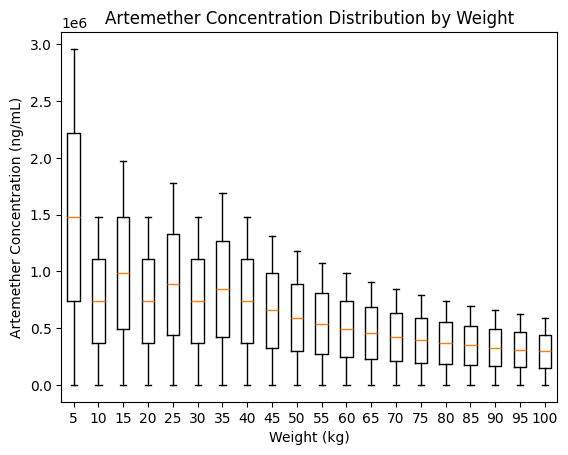

In [51]:
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by Weight')

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

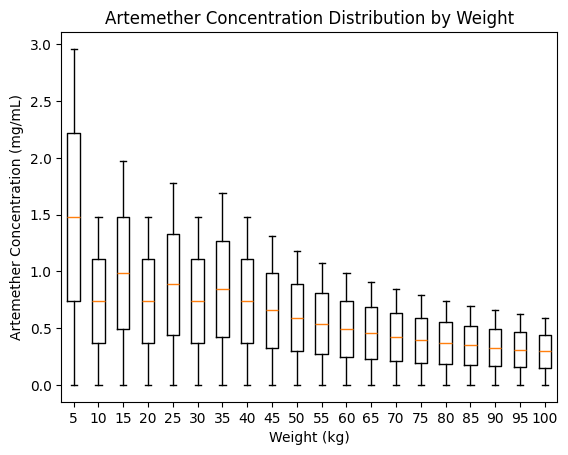

In [52]:
plt.boxplot(artemether_concentrations_mg_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (mg/mL)')
plt.title('Artemether Concentration Distribution by Weight')

In [53]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

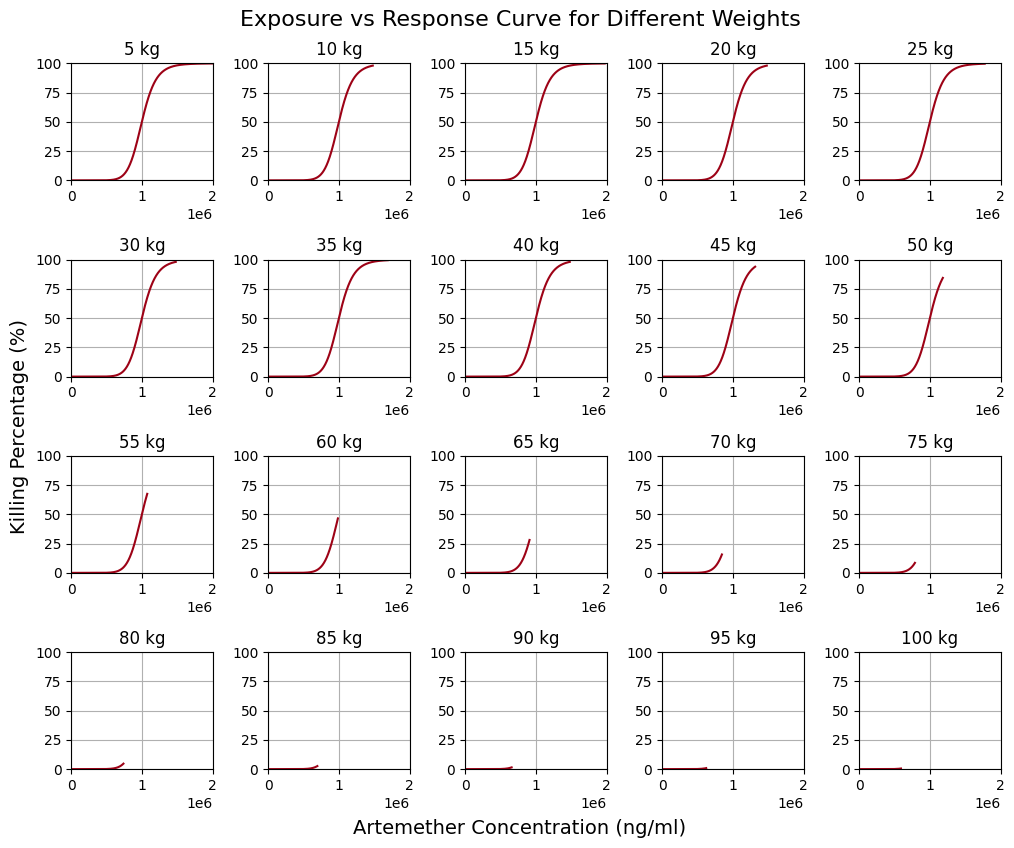

In [54]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

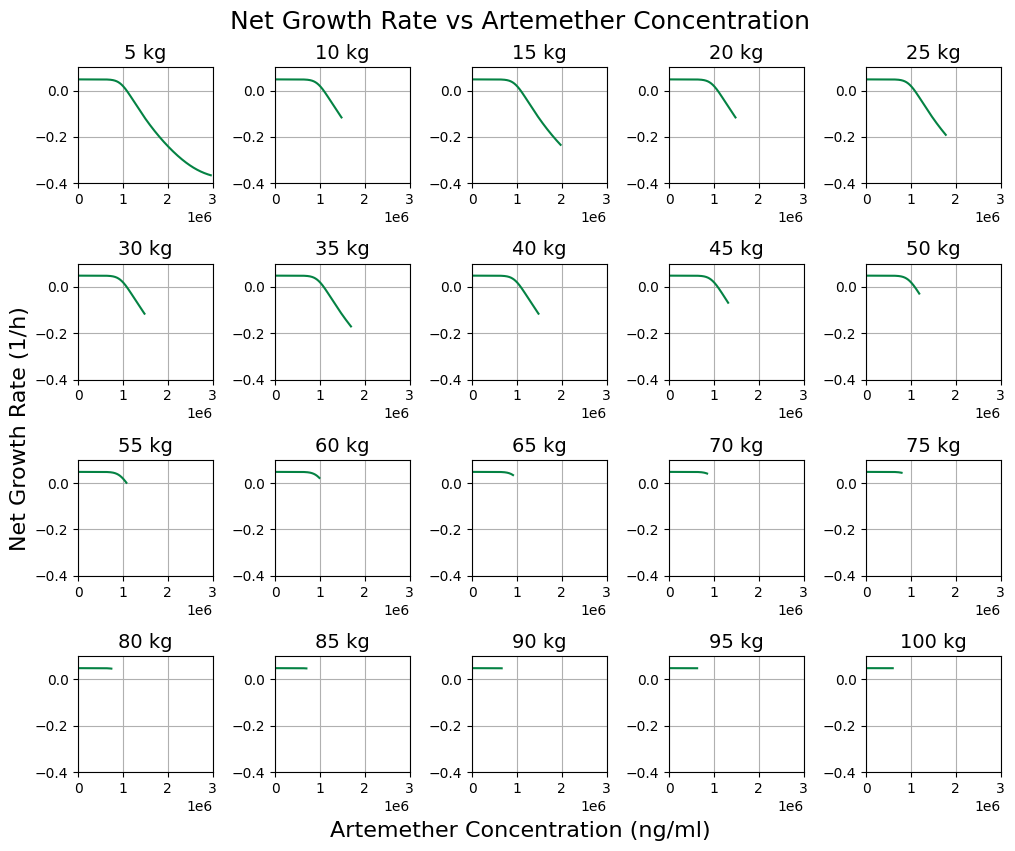

In [55]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 3*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

In [56]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_mg_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_mg_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_mg[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

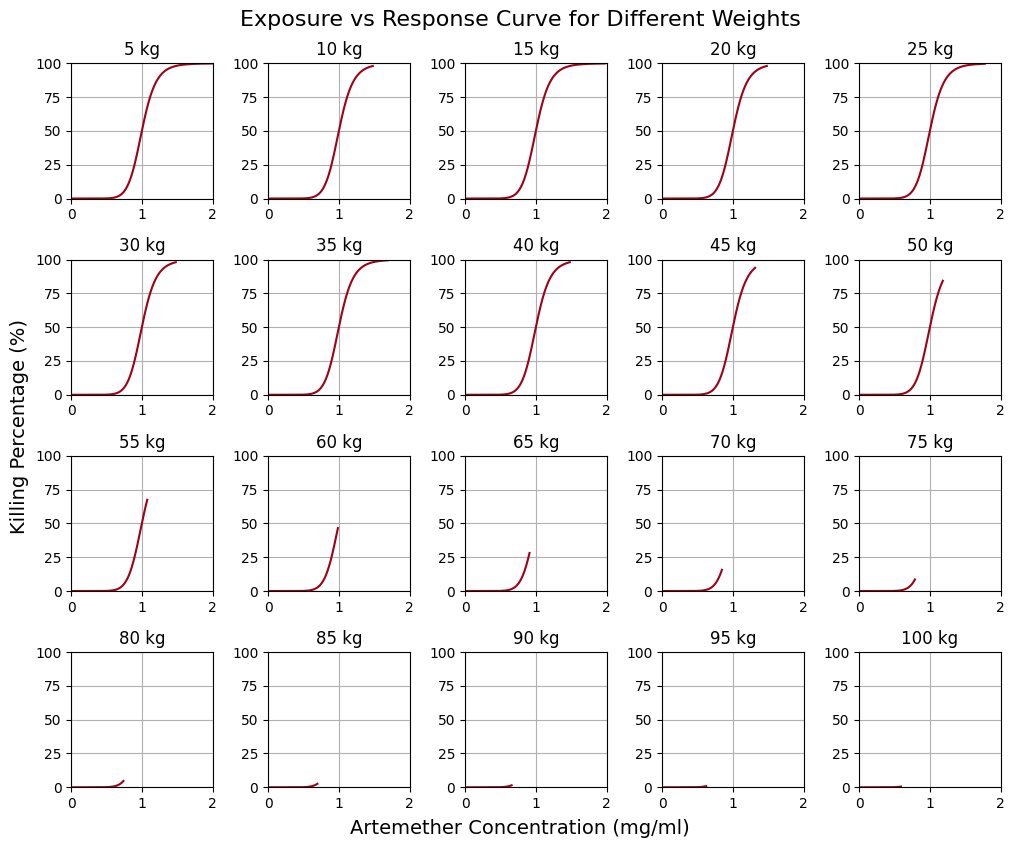

In [57]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

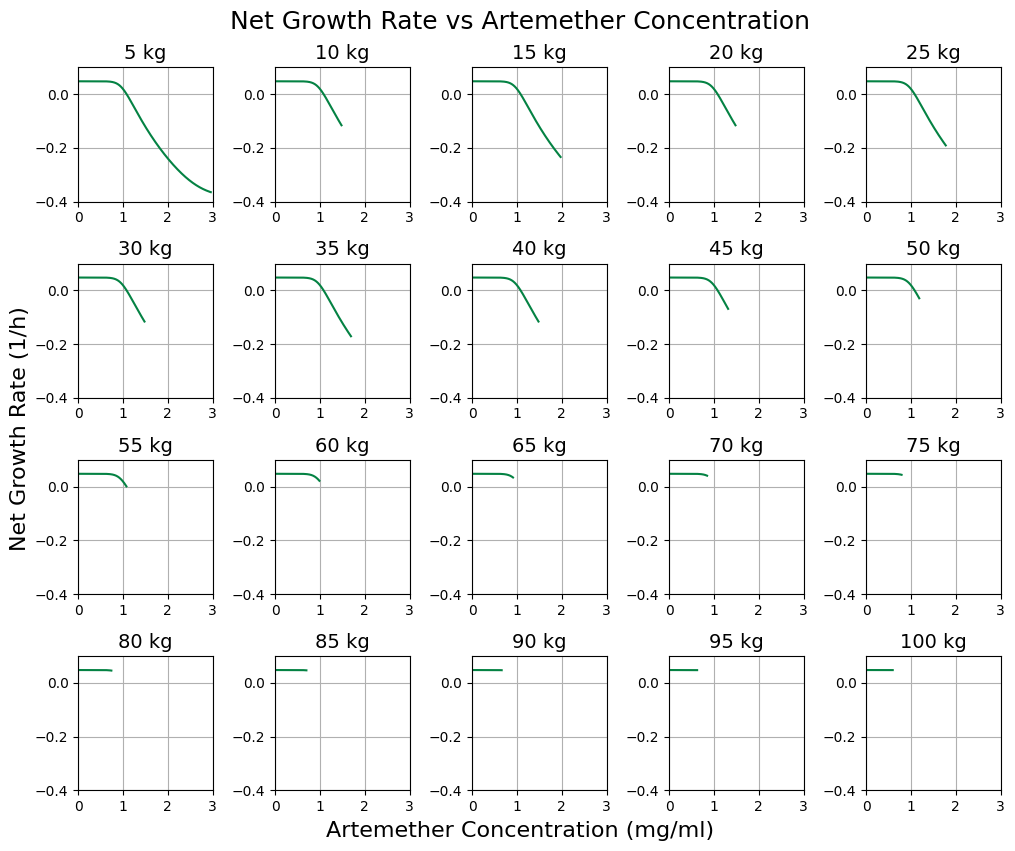

In [58]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 3)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

<br>

# x = 0.75

In [59]:
# Generating total dose for each weight over 3 days with twice daily dosing
weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
# for i in range(len(weight_values)):
#     print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

for i in range(len(weight_values)):
    total_blood_volume = weight_values[i] * (((70 / np.sqrt(24.9 / 22)))**0.75) 
    lower_limit_concentration.append(lower_limit_mg[i] / total_blood_volume)
    upper_limit_concentration.append(upper_limit_mg[i] / total_blood_volume)

artemether_concentrations_mg_ml_final = []
for i in range(len(weight_values)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 10
ec50_concentrations_ng = [ec50_dose_ng for weight in weight_values] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for weight in weight_values]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

EC50 Concentrations (ng/mL): [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
EC50 Concentrations (mg/mL): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [60]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 5 kg is: 0.0 ng/mL to 1038852.6729586694 ng/mL
Total Concentration range for weight 10 kg is: 0.0 ng/mL to 519426.3364793347 ng/mL
Total Concentration range for weight 15 kg is: 0.0 ng/mL to 692568.4486391129 ng/mL
Total Concentration range for weight 20 kg is: 0.0 ng/mL to 519426.3364793347 ng/mL
Total Concentration range for weight 25 kg is: 0.0 ng/mL to 623311.6037752016 ng/mL
Total Concentration range for weight 30 kg is: 0.0 ng/mL to 519426.3364793347 ng/mL
Total Concentration range for weight 35 kg is: 0.0 ng/mL to 593630.0988335252 ng/mL
Total Concentration range for weight 40 kg is: 0.0 ng/mL to 519426.3364793347 ng/mL
Total Concentration range for weight 45 kg is: 0.0 ng/mL to 461712.29909274186 ng/mL
Total Concentration range for weight 50 kg is: 0.0 ng/mL to 415541.06918346765 ng/mL
Total Concentration range for weight 55 kg is: 0.0 ng/mL to 377764.608348607 ng/mL
Total Concentration range for weight 60 kg is: 0.0 ng/mL to 346284.22431955

In [61]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_mg_ml_final[i][0]} mg/mL to {artemether_concentrations_mg_ml_final[i][-1]} mg/mL")

Total Concentration range for weight 5 kg is: 0.0 mg/mL to 1.0388526729586693 mg/mL
Total Concentration range for weight 10 kg is: 0.0 mg/mL to 0.5194263364793347 mg/mL
Total Concentration range for weight 15 kg is: 0.0 mg/mL to 0.6925684486391128 mg/mL
Total Concentration range for weight 20 kg is: 0.0 mg/mL to 0.5194263364793347 mg/mL
Total Concentration range for weight 25 kg is: 0.0 mg/mL to 0.6233116037752016 mg/mL
Total Concentration range for weight 30 kg is: 0.0 mg/mL to 0.5194263364793347 mg/mL
Total Concentration range for weight 35 kg is: 0.0 mg/mL to 0.5936300988335252 mg/mL
Total Concentration range for weight 40 kg is: 0.0 mg/mL to 0.5194263364793347 mg/mL
Total Concentration range for weight 45 kg is: 0.0 mg/mL to 0.46171229909274186 mg/mL
Total Concentration range for weight 50 kg is: 0.0 mg/mL to 0.41554106918346767 mg/mL
Total Concentration range for weight 55 kg is: 0.0 mg/mL to 0.37776460834860703 mg/mL
Total Concentration range for weight 60 kg is: 0.0 mg/mL to 0.3

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

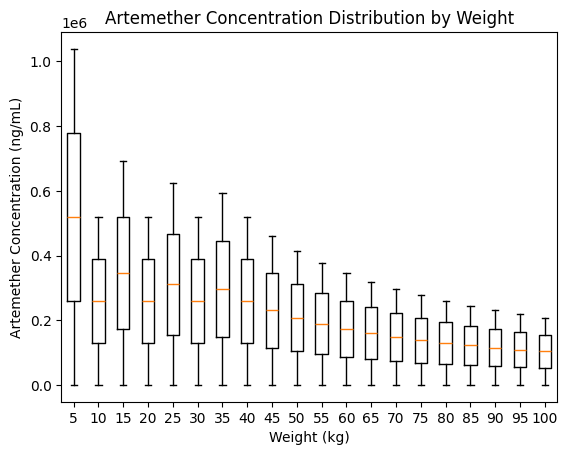

In [62]:
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by Weight')

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

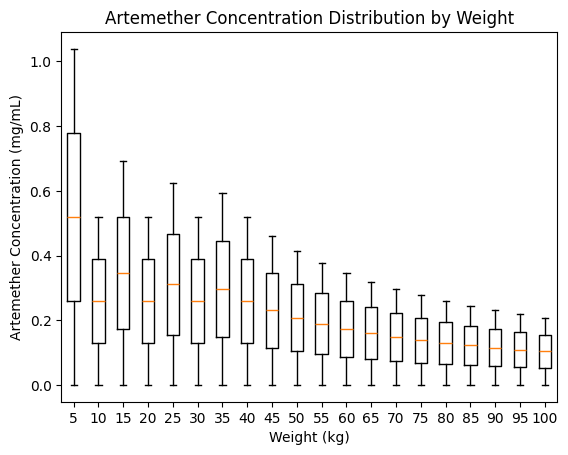

In [63]:
plt.boxplot(artemether_concentrations_mg_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (mg/mL)')
plt.title('Artemether Concentration Distribution by Weight')

In [64]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

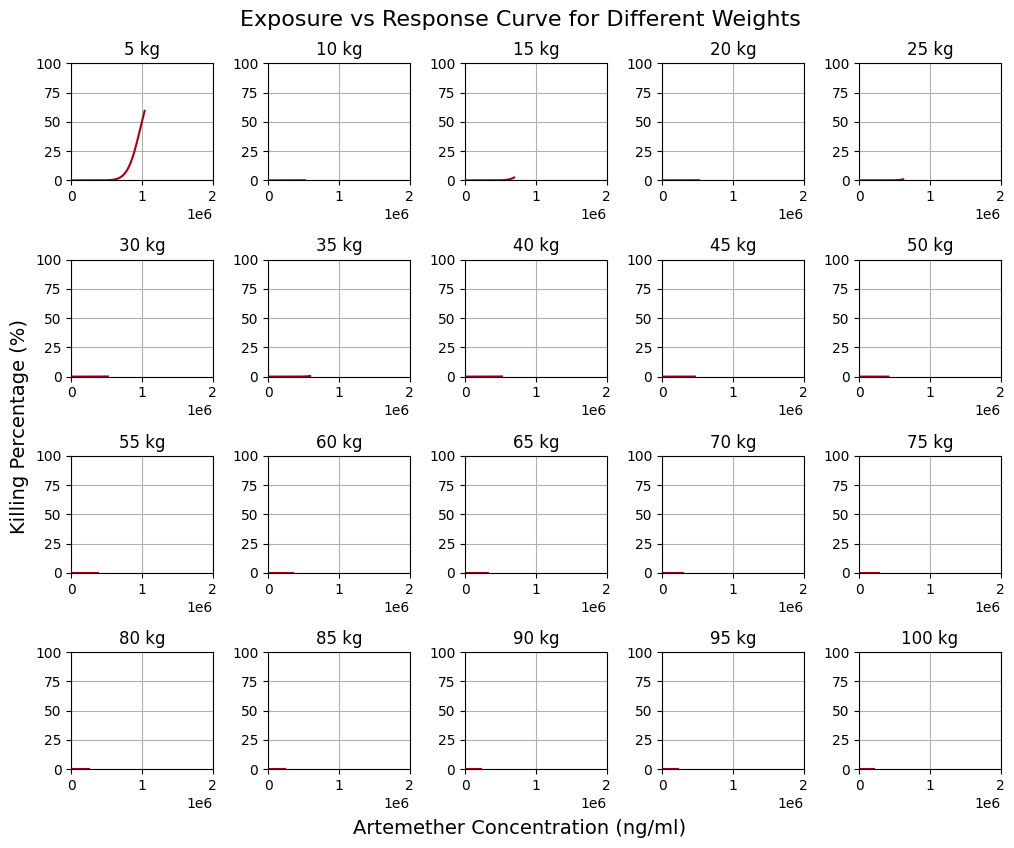

In [65]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

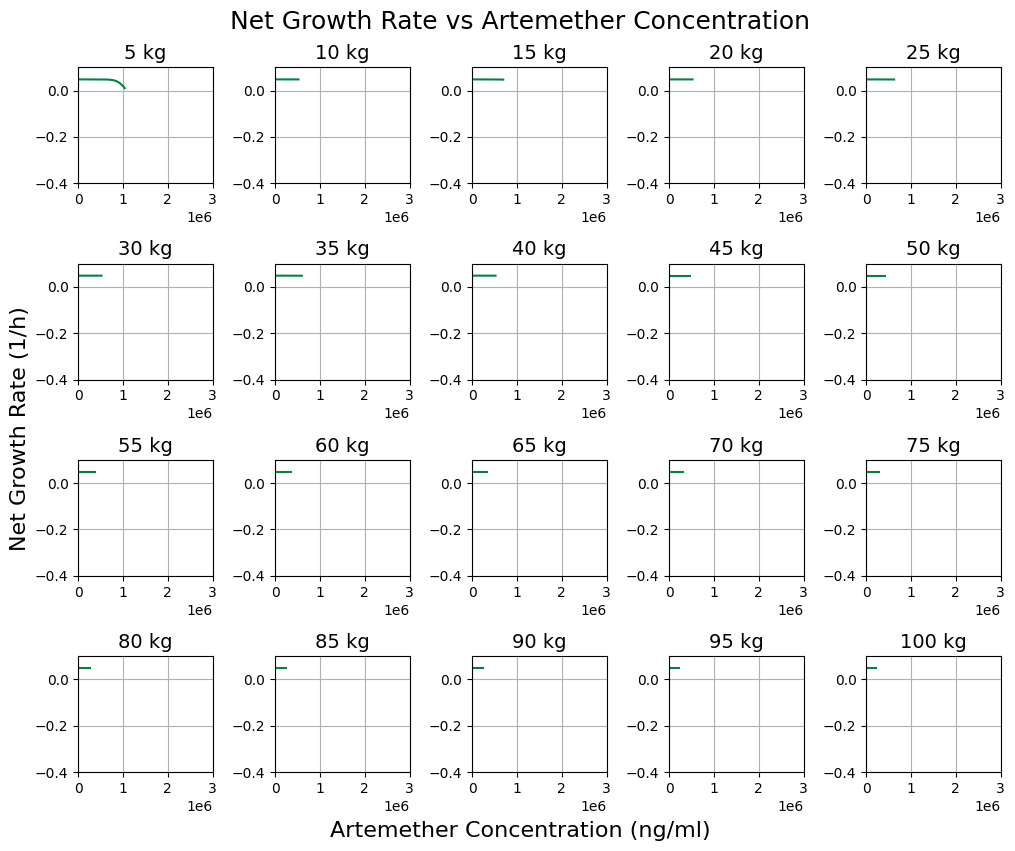

In [66]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 3*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

In [67]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_mg_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_mg_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_mg[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

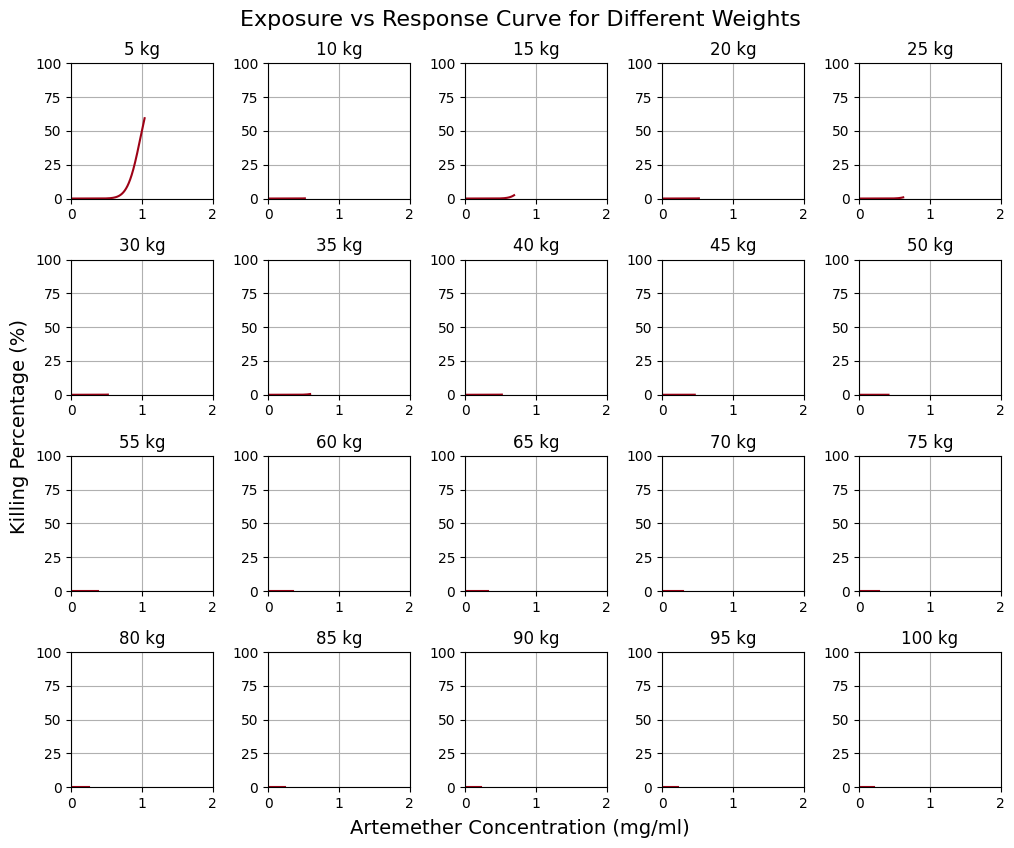

In [68]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

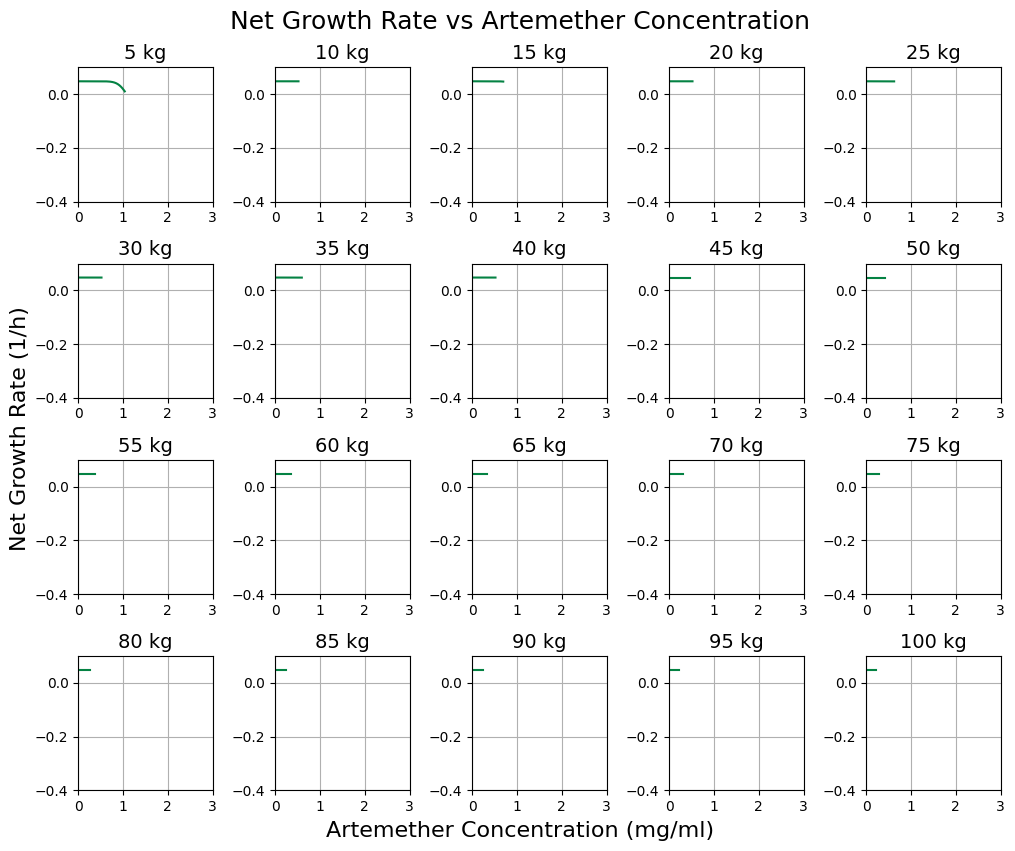

In [69]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 3)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

<br>

# x = 1.5

In [70]:
# Generating total dose for each weight over 3 days with twice daily dosing
weight_values = list(range(5, 101, 5))  # Re-defining weight values for clarity
total_dose_mg = []

for weight in weight_values:
    total_mg_dose = generate_recommended_dosing_schedule(weight) * 6  # Assuming 3 days of treatment
    total_dose_mg.append(total_mg_dose)
# for i in range(len(weight_values)):
#     print(f"Total dose for weight {weight_values[i]} kg: {total_dose_mg[i]} mg")

upper_limit_mg = total_dose_mg
lower_limit_mg = [0] * len(weight_values)

lower_limit_concentration = []
upper_limit_concentration = []

for i in range(len(weight_values)):
    total_blood_volume = weight_values[i] * (((70 / np.sqrt(24.9 / 22)))**1.5) 
    lower_limit_concentration.append(lower_limit_mg[i] / total_blood_volume)
    upper_limit_concentration.append(upper_limit_mg[i] / total_blood_volume)

artemether_concentrations_mg_ml_final = []
for i in range(len(weight_values)):
    temp_conc = np.linspace(lower_limit_concentration[i], upper_limit_concentration[i], 1000)
    artemether_concentrations_mg_ml_final.append(temp_conc)

#Convert artemether_concentrations_ng_ml_final to artemether_concentrations_mg_ml_final
artemether_concentrations_ng_ml_final = []
for i in range(len(artemether_concentrations_mg_ml_final)):
    temp_conc = artemether_concentrations_mg_ml_final[i] * (10**6)  # Convert mg/mL to ng/mL
    artemether_concentrations_ng_ml_final.append(temp_conc)

pmax = 0.99997
ec50_dose_ng = 1*(10**6)  # Convert ng/mL to ng/mg
ec50_dose_mg = 1  
n = 10
ec50_concentrations_ng = [ec50_dose_ng for weight in weight_values] # Assuming ec50 is already a concentration
ec50_concentrations_mg = [ec50_dose_mg for weight in weight_values]  # Convert ng/mL to mg/mL

print("EC50 Concentrations (ng/mL):", ec50_concentrations_ng)
print("EC50 Concentrations (mg/mL):", ec50_concentrations_mg)

EC50 Concentrations (ng/mL): [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
EC50 Concentrations (mg/mL): [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [71]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_ng_ml_final[i][0]} ng/mL to {artemether_concentrations_ng_ml_final[i][-1]} ng/mL")

Total Concentration range for weight 5 kg is: 0.0 ng/mL to 44967.28650472384 ng/mL
Total Concentration range for weight 10 kg is: 0.0 ng/mL to 22483.64325236192 ng/mL
Total Concentration range for weight 15 kg is: 0.0 ng/mL to 29978.191003149223 ng/mL
Total Concentration range for weight 20 kg is: 0.0 ng/mL to 22483.64325236192 ng/mL
Total Concentration range for weight 25 kg is: 0.0 ng/mL to 26980.3719028343 ng/mL
Total Concentration range for weight 30 kg is: 0.0 ng/mL to 22483.64325236192 ng/mL
Total Concentration range for weight 35 kg is: 0.0 ng/mL to 25695.59228841362 ng/mL
Total Concentration range for weight 40 kg is: 0.0 ng/mL to 22483.64325236192 ng/mL
Total Concentration range for weight 45 kg is: 0.0 ng/mL to 19985.460668766147 ng/mL
Total Concentration range for weight 50 kg is: 0.0 ng/mL to 17986.91460188953 ng/mL
Total Concentration range for weight 55 kg is: 0.0 ng/mL to 16351.740547172303 ng/mL
Total Concentration range for weight 60 kg is: 0.0 ng/mL to 14989.095501574

In [72]:
#Checking if the total dose in nanograms and milligrams are correct
for i in range(len(weight_values)):
    print(f"Total Concentration range for weight {weight_values[i]} kg is: {artemether_concentrations_mg_ml_final[i][0]} mg/mL to {artemether_concentrations_mg_ml_final[i][-1]} mg/mL")

Total Concentration range for weight 5 kg is: 0.0 mg/mL to 0.044967286504723834 mg/mL
Total Concentration range for weight 10 kg is: 0.0 mg/mL to 0.022483643252361917 mg/mL
Total Concentration range for weight 15 kg is: 0.0 mg/mL to 0.02997819100314922 mg/mL
Total Concentration range for weight 20 kg is: 0.0 mg/mL to 0.022483643252361917 mg/mL
Total Concentration range for weight 25 kg is: 0.0 mg/mL to 0.0269803719028343 mg/mL
Total Concentration range for weight 30 kg is: 0.0 mg/mL to 0.022483643252361917 mg/mL
Total Concentration range for weight 35 kg is: 0.0 mg/mL to 0.02569559228841362 mg/mL
Total Concentration range for weight 40 kg is: 0.0 mg/mL to 0.022483643252361917 mg/mL
Total Concentration range for weight 45 kg is: 0.0 mg/mL to 0.019985460668766147 mg/mL
Total Concentration range for weight 50 kg is: 0.0 mg/mL to 0.01798691460188953 mg/mL
Total Concentration range for weight 55 kg is: 0.0 mg/mL to 0.016351740547172304 mg/mL
Total Concentration range for weight 60 kg is: 0.

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

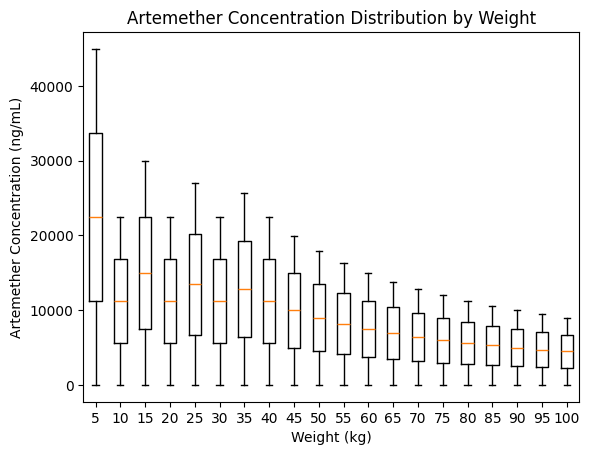

In [73]:
plt.boxplot(artemether_concentrations_ng_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (ng/mL)')
plt.title('Artemether Concentration Distribution by Weight')

Text(0.5, 1.0, 'Artemether Concentration Distribution by Weight')

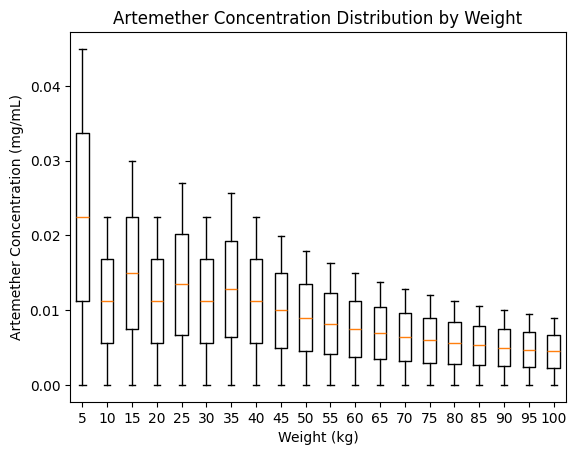

In [74]:
plt.boxplot(artemether_concentrations_mg_ml_final, tick_labels=weight_values)
plt.xlabel('Weight (kg)')
plt.ylabel('Artemether Concentration (mg/mL)')
plt.title('Artemether Concentration Distribution by Weight')

In [75]:
kill_fraction = []
killing_rates = []

for i in range(0, len(artemether_concentrations_ng_ml_final)):
    temp_kill_fraction = []
    temp_killing_rates = []
    for concentration in artemether_concentrations_ng_ml_final[i]:
        temp_kill_fraction.append(sigmoid_function(concentration, pmax, ec50_concentrations_ng[i], n))
        temp_killing_rates.append((-1/24) * np.log(1.0 - temp_kill_fraction[-1]))
    kill_fraction.append(temp_kill_fraction)
    killing_rates.append(temp_killing_rates)

growth_rate = 0.048 
effect = [] 

for i in range(len(killing_rates)):
    effect.append(growth_rate - np.array(killing_rates[i]))

kill_percent = []
for i in range(len(kill_fraction)):
    temp_kill_percent = []
    for j in range(len(kill_fraction[i])):
        temp_kill_percent.append(kill_fraction[i][j] * 100)
    kill_percent.append(temp_kill_percent)

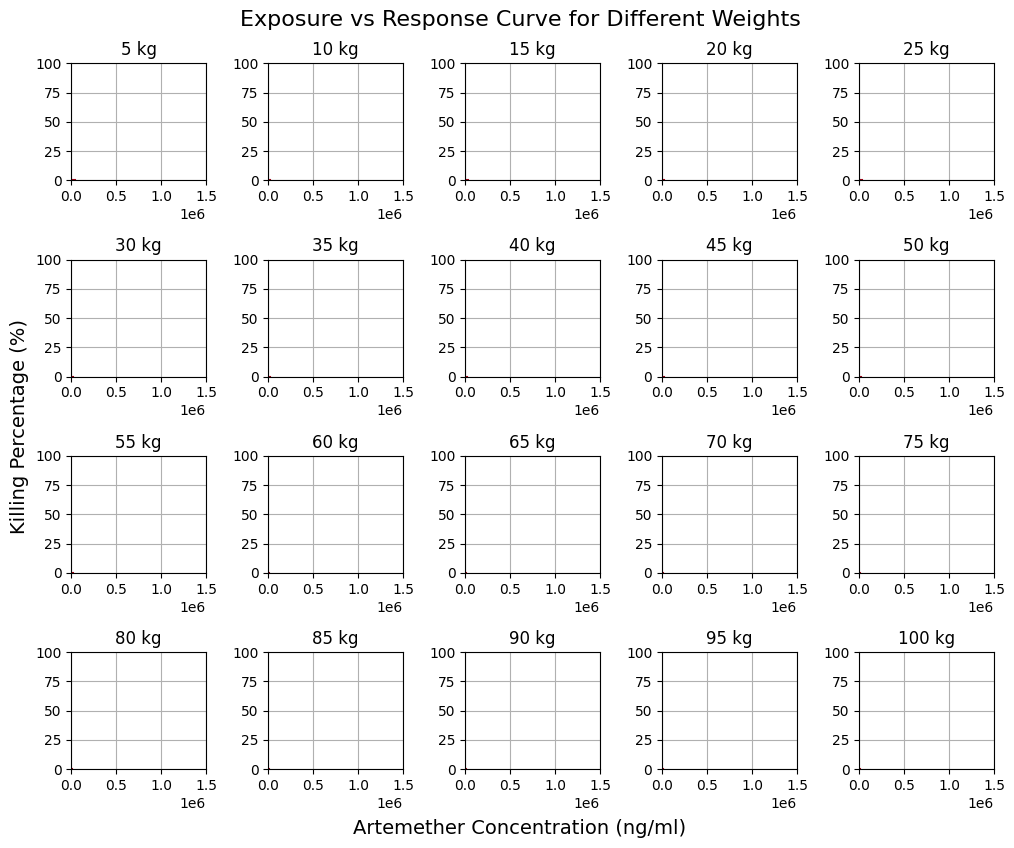

In [82]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 1.5*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

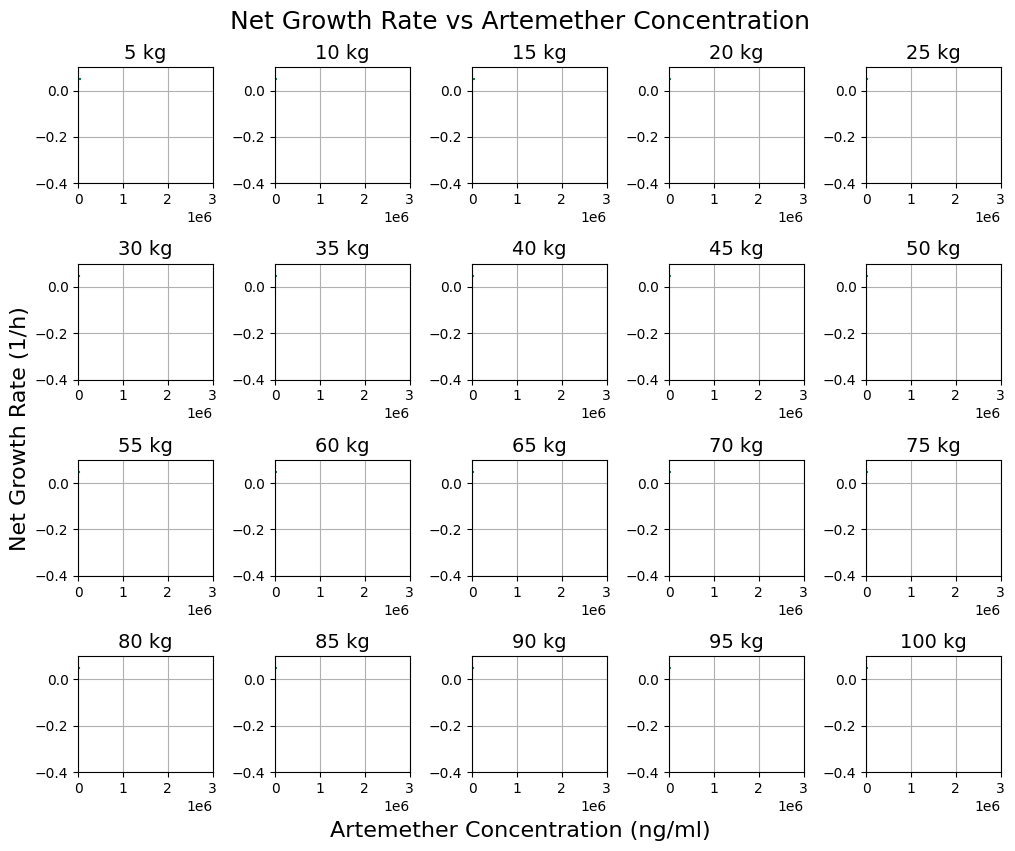

In [83]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_ng_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 3*10**6)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (ng/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

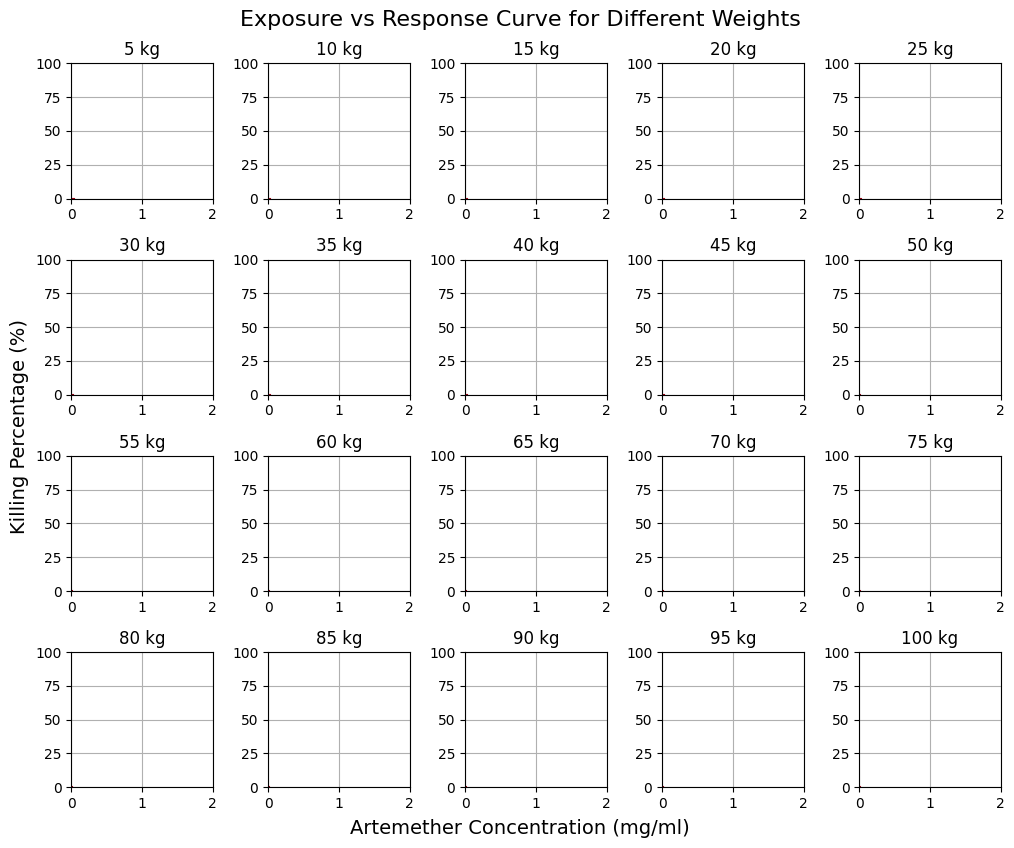

In [84]:
# Creating subplots for each weight for only killing percentage
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], kill_percent[i], label=f'Weight: {weight_values[i]} kg', color='#9d0216')
    # axs[i // 5, i % 5].set_xlabel('Artemether Concentration (ng/ml)')
    # axs[i // 5, i % 5].set_ylabel('Killing Percentage (%)')
    axs[i // 5, i % 5].set_xlim(0, 2)  # Adjusted for mg/mL
    axs[i // 5, i % 5].set_ylim(0, 100)
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=12)
    axs[i // 5, i % 5].grid()
#Setting common labels for the entire figure
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Killing Percentage (%)', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 1.0, 'Exposure vs Response Curve for Different Weights', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

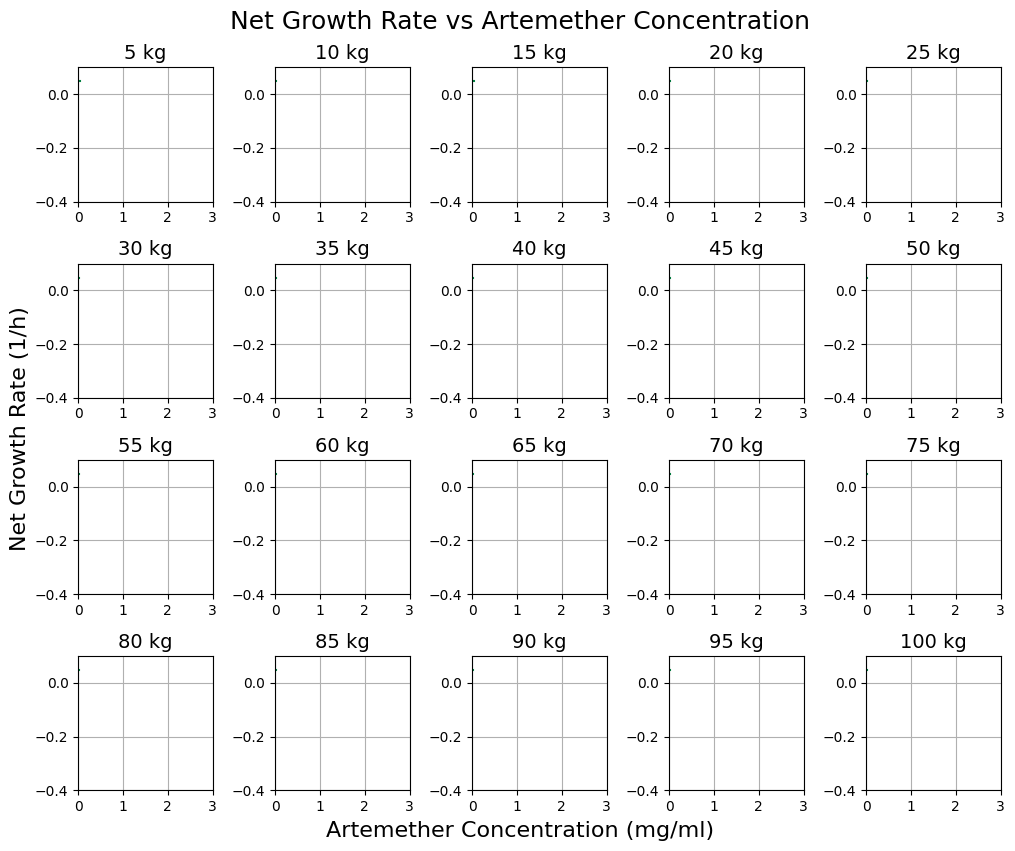

In [85]:
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
for i in range(len(weight_values)):
    axs[i // 5, i % 5].plot(artemether_concentrations_mg_ml_final[i], effect[i], label=f'Weight: {weight_values[i]} kg', color="#048243")
    axs[i // 5, i % 5].set_title(f'{weight_values[i]} kg', fontsize=14)
    axs[i // 5, i % 5].set_xlim(0, 3)  # Adjusted for ng/mL
    axs[i // 5, i % 5].set_ylim(-0.4, 0.1)
    axs[i // 5, i % 5].grid()
    #axs[i // 5, i % 5].legend(loc='upper right', bbox_to_anchor=(1.25, 1))
fig.text(0.5, -0.01, 'Artemether Concentration (mg/ml)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, 'Net Growth Rate (1/h)', va='center', rotation='vertical', fontsize=16)
fig.text(0.5, 1.0, 'Net Growth Rate vs Artemether Concentration', ha='center', fontsize=18)
plt.tight_layout()
plt.show()

# Higher x values make the curves worse